# <u>**Лабораторная работа 2.**</u>
# Логистическая и линейная регрессия
## *Задача классификации*



### Импорт необходимых библиотек

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [68]:
data = pd.read_csv("../WineQT.csv")  

### Разделение на признаки и целевую переменную

In [69]:
X = data.drop(columns=["quality"])  # Все кроме качества
y = data["quality"]  # Качество (целевая)

### Подготовка данных, обучение и оценка качества модели

Accuracy: 0.7580174927113703
F1-Score: 0.7786666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       152
           1       0.79      0.76      0.78       191

    accuracy                           0.76       343
   macro avg       0.76      0.76      0.76       343
weighted avg       0.76      0.76      0.76       343



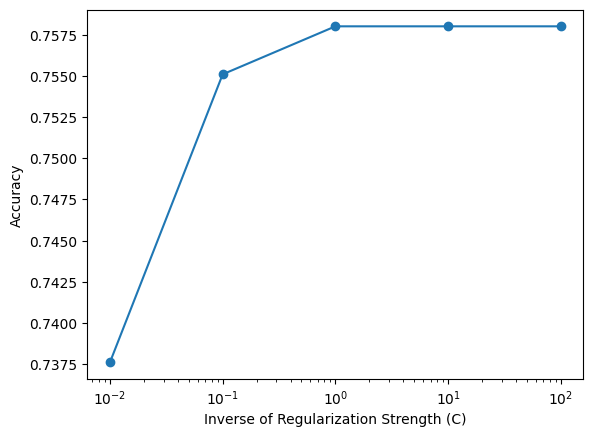

In [70]:


# Бинаризация целевой переменной для классификации (например, хорошее/плохое качество)
y = (y >= 6).astype(int)  # Вино хорошего качества, если оценка >= 6

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение модели логистической регрессии
logreg = LogisticRegression(random_state=42, solver='liblinear')  # Используем solver для небольшой/средней выборки
logreg.fit(X_train, y_train)

# Предсказания
y_pred = logreg.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Анализ зависимости качества от регуляризации (параметр C)
c_values = [0.01, 0.1, 1, 10, 100]
accuracies = []

for c in c_values:
    logreg = LogisticRegression(C=c, random_state=42, solver='liblinear')
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(c_values, accuracies, marker='o')
plt.xscale('log')  # Логарифмическая шкала для C
plt.xlabel('Inverse of Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.title('')
plt.show()


## Улучшенный бейзлайн











### *Создание полиномиальных признаков*: Полиномиальные признаки создаются с помощью функции PolynomialFeatures. Эта функция возводит исходные признаки в степень до указанной степени (в данном случае 2), что позволяет добавлять нелинейность в данные и потенциально улучшить производительность модели.

In [71]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)  

###    *Обработка дисбаланса классов через SMOTE*: Метод SMOTE используется для создания синтетических примеров меньшинства класса, чтобы сбалансировать классы перед обучением модели. Это важно, так как дисбаланс классов может привести к смещению модели в сторону большинства класса.

In [72]:
# Обработка дисбаланса классов через SMOTE
smote = SMOTE(random_state=42)
X_train_poly, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

###    *Задание параметров для GridSearchCV*: Параметры для оптимизации гиперпараметров модели задаются в словаре param_grid.


In [73]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Параметр обратной силы регуляризации
    'penalty': ['l1', 'l2'],       # Тип регуляризации (L1 - Lasso, L2 - Ridge)
    'solver': ['liblinear', 'saga']  # Подходящие решатели для l1 и l2
}


logreg = LogisticRegression(max_iter=500, random_state=42)

###    Оптимизация модели с помощью GridSearchCV: Для нахождения наилучших значений гиперпараметров используется кросс-валидация с 5 фолдами (cv=5) и метрикой F1 для оценки качества модели. По завершении процесса выбирается лучшая комбинация параметров.

In [74]:
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_poly, y_train_balanced)


print("Лучшие параметры:", grid_search.best_params_)


best_logreg = grid_search.best_estimator_

Лучшие параметры: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


###    Предсказания на тестовых данных: Тестовые данные преобразуются с помощью тех же полиномиальных признаков, что и тренировочные данные, после чего делается прогноз.

In [75]:

best_logreg.fit(X_train_poly, y_train_balanced)


X_test_poly = poly.transform(X_test)  
y_pred = best_logreg.predict(X_test_poly)

###    *Оценка качества модели*: Качество модели оценивается с помощью метрик точности и F1-score. Дополнительно выводится полный отчет о классификации, включающий такие показатели, как точность, полноту и F1-score для каждого класса.

In [76]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Accuracy (улучшенный бейзлайн):", accuracy)
print("F1-Score (улучшенный бейзлайн):", f1)
print("Classification Report (улучшенный бейзлайн):")
print(classification_report(y_test, y_pred))

Accuracy (улучшенный бейзлайн): 0.7084548104956269
F1-Score (улучшенный бейзлайн): 0.7206703910614525
Classification Report (улучшенный бейзлайн):
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       152
           1       0.77      0.68      0.72       191

    accuracy                           0.71       343
   macro avg       0.71      0.71      0.71       343
weighted avg       0.72      0.71      0.71       343



###    График зависимости точности от регуляризации

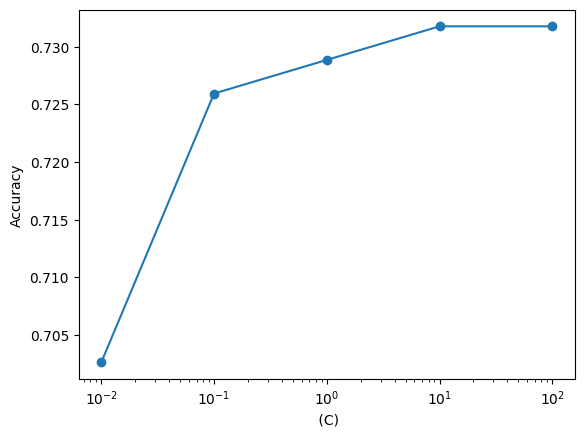

In [77]:
c_values = [0.01, 0.1, 1, 10, 100]
accuracies = []

for c in c_values:
    logreg = LogisticRegression(C=c, penalty='l2', solver='liblinear', max_iter=500, random_state=42)
    logreg.fit(X_train_poly, y_train_balanced)
    y_pred = logreg.predict(X_test_poly)
    accuracies.append(accuracy_score(y_test, y_pred))

# Построение графика
plt.plot(c_values, accuracies, marker='o')
plt.xscale('log')  # Логарифмическая шкала для C
plt.xlabel(' (C)')
plt.ylabel('Accuracy')
plt.title('')
plt.show()

## ***Выводы*** 
### После улучшений, включающих добавление полиномиальных признаков степени 2 и балансировку классов с помощью SMOTE, результаты модели ухудшились. До изменений модель показывала точность 75.8% и F1-метрику 77.9%, а после — 70.8% и 72.0% соответственно. Это ухудшение может быть связано с переусложнением модели из-за добавления полиномиальных признаков, которые увеличили количество взаимодействий между признаками, что затруднило обобщение. Кроме того, синтетические данные, созданные методом SMOTE, могли сместить распределение выборки и оказаться недостаточно репрезентативными для тестовых данных. Также возможно, что исходных признаков было достаточно, а добавление новых только усложнило модель без улучшения её производительности.

## Самостоятельная имплементация логистической регрессии

### Логистическая регрессия используется для бинарной классификации, предсказывая вероятность принадлежности объекта к классу. Алгоритм начинает с инициализации весов и добавления смещения. На этапе обучения вычисляется линейная комбинация признаков, преобразованная через сигмоиду в вероятности. Затем градиентный спуск минимизирует ошибку, обновляя веса. 

In [78]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        # Добавляем единичный столбец для учета смещения (bias)
        self.X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.y = y
        self.weights = np.zeros(self.X.shape[1])  # Инициализация весов
        
        # Градиентный спуск
        for _ in range(self.n_iterations):
            z = np.dot(self.X, self.weights)
            predictions = self.sigmoid(z)
            gradient = np.dot(self.X.T, (predictions - self.y)) / self.y.size
            self.weights -= self.learning_rate * gradient  # Обновление весов
    
    def predict(self, X):
        # Добавляем единичный столбец для учета смещения (bias)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        z = np.dot(X, self.weights)
        probabilities = self.sigmoid(z)
        return (probabilities >= 0.5).astype(int)


logreg_custom = CustomLogisticRegression(learning_rate=0.01, n_iterations=1000)
logreg_custom.fit(X_train, y_train)
y_pred_custom = logreg_custom.predict(X_test)


print("\n=== Собственная реализация логистической регрессии ===")
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("F1-Score:", f1_score(y_test, y_pred_custom))
print("Classification Report:")
print(classification_report(y_test, y_pred_custom))





=== Собственная реализация логистической регрессии ===
Accuracy: 0.7434402332361516
F1-Score: 0.7621621621621621
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       152
           1       0.79      0.74      0.76       191

    accuracy                           0.74       343
   macro avg       0.74      0.74      0.74       343
weighted avg       0.75      0.74      0.74       343



## ***Выводы***

### Встроенная реализация показала лучшую точность (accuracy = 0.758) и F1-метрику (F1-score = 0.779), по сравнению с собственной реализацией (accuracy = 0.743, F1-score = 0.762). Метрики precision и recall также выше у встроенной версии для обоих классов. Например, precision для класса 1 составляет 0.79 у встроенной модели против 0.79 у собственной, но при этом F1-метрика выше у встроенной реализации.

# Самостоятельная имплементация логистической регрессии с улучшенным бейзлайном

In [79]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_poly_balanced, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

# Оптимизация гиперпараметров (поиск оптимального learning_rate и n_iterations)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_iterations': [500, 1000, 2000]
}

# Ручной перебор параметров
best_params = None
best_f1 = 0
for learning_rate in param_grid['learning_rate']:
    for n_iterations in param_grid['n_iterations']:
        logreg_custom = CustomLogisticRegression(learning_rate=learning_rate, n_iterations=n_iterations)
        logreg_custom.fit(X_train_poly_balanced, y_train_balanced)
        y_pred_custom = logreg_custom.predict(X_test_poly)
        f1 = f1_score(y_test, y_pred_custom)
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'learning_rate': learning_rate, 'n_iterations': n_iterations}

print("Лучшие параметры для CustomLogisticRegression:", best_params)

# Обучение с лучшими параметрами
logreg_custom_best = CustomLogisticRegression(**best_params)
logreg_custom_best.fit(X_train_poly_balanced, y_train_balanced)
y_pred_custom_best = logreg_custom_best.predict(X_test_poly)

# Оценка качества
accuracy_custom = accuracy_score(y_test, y_pred_custom_best)
f1_custom = f1_score(y_test, y_pred_custom_best)

print("Accuracy (CustomLogisticRegression улучшенный бейзлайн):", accuracy_custom)
print("F1-Score (CustomLogisticRegression улучшенный бейзлайн):", f1_custom)
print("Classification Report (CustomLogisticRegression улучшенный бейзлайн):")
print(classification_report(y_test, y_pred_custom_best))




Лучшие параметры для CustomLogisticRegression: {'learning_rate': 0.05, 'n_iterations': 2000}
Accuracy (CustomLogisticRegression улучшенный бейзлайн): 0.7346938775510204
F1-Score (CustomLogisticRegression улучшенный бейзлайн): 0.7506849315068493
Classification Report (CustomLogisticRegression улучшенный бейзлайн):
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       152
           1       0.79      0.72      0.75       191

    accuracy                           0.73       343
   macro avg       0.73      0.74      0.73       343
weighted avg       0.74      0.73      0.74       343



## ***Выводы***
### Собственная реализация логистической регрессии продемонстрировала лучшие результаты по всем ключевым метрикам. Точность (accuracy) для встроенной модели составила 70.8%, в то время как собственная модель показала 73.4%. F1-метрика также была выше у собственной реализации: 75.1% против 72.0% у встроенной. Особенно заметна разница в показателях precision и recall для целевого класса 1. Встроенная модель достигла precision = 0.77, recall = 0.68 и F1 = 0.72, тогда как собственная модель продемонстрировала precision = 0.79, recall = 0.72 и F1 = 0.75. Эти результаты показывают, что собственная реализация лучше справляется с нахождением и классификацией положительных объектов.

## *Задача регрессии*

In [80]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
data = pd.read_csv("cars.csv")


### Препроцессинг данных, обучение и оценка модели

In [81]:
# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Price', axis=1)
y = data['Price']

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии


lr = LinearRegression()
lr.fit(X_train, y_train)

# Прогнозирование
y_pred = lr.predict(X_val)

# Оценка качества модели
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)


MAE: 4.0184465803921565
MSE: 66.15471641119554
R²: 0.462416792126917


## Улучшенный бейзлайн

### Прецпроцесинг (аналогично предыдущему пункту)

In [89]:
# Загрузка данных
data = pd.read_csv("cars.csv")

# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

### Удаление выбросов по цене (верхние 1% значений)

In [90]:
data = data[data['Price'] < data['Price'].quantile(0.99)]

### Создание новых признаков и предобработка данных

In [91]:
data['Age'] = 2024 - data['Year']
data['Power_to_Weight'] = data['Power'] / data['Engine']
data['Log_Price'] = np.log1p(data['Price'])  # Логарифмируем цену
data['Log_Kilometers'] = np.log1p(data['Kilometers_Driven'])  # Логарифмируем пробег

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price', 'Year', 'Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Log_Price', axis=1)
y = data['Log_Price']

### Анализ данных и нормализация признаков

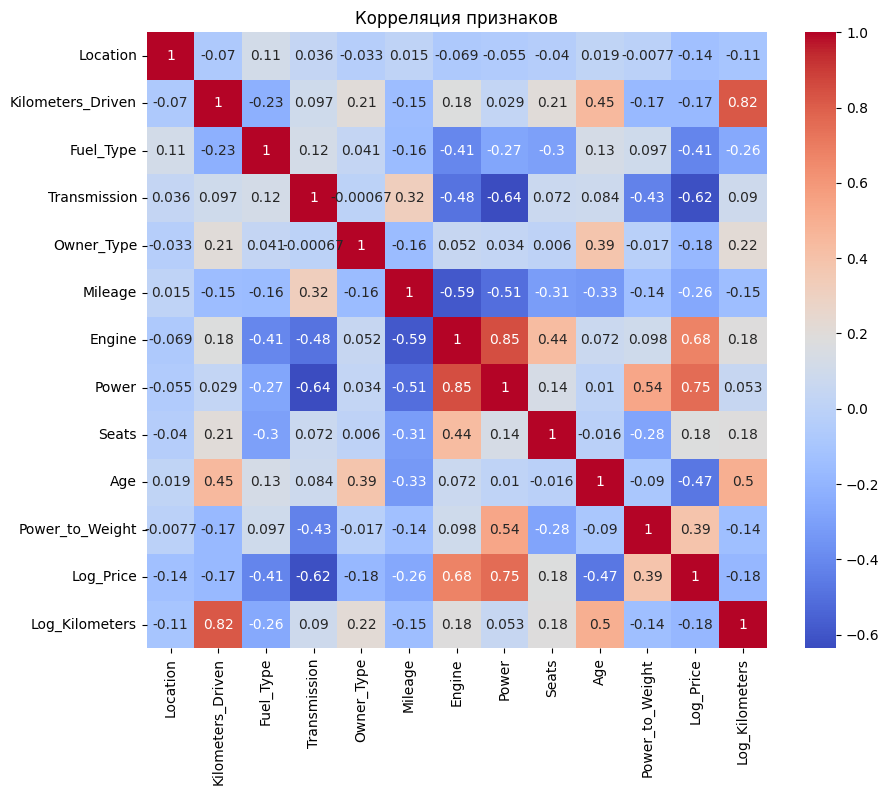

In [92]:
# Визуализация корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()


scaler = StandardScaler()
X = scaler.fit_transform(X)

### Создаётся модель  и настраиваются её гиперпараметры с помощью GridSearchCV, чтобы найти оптимальные параметры.

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели линейной регрессии
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

lr = Ridge()  # Используем Ridge (линейная регрессия с регуляризацией)

# Настройка гиперпараметров для GridSearchCV
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Регуляризационный параметр
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']  # Методы решения
}

# Поиск лучших гиперпараметров с использованием GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Используем MAE в качестве метрики
    cv=5,  # 5-кратная кросс-валидация
    n_jobs=-1,  # Используем все доступные ядра
    verbose=2
)

grid_search.fit(X_train, y_train)

# Вывод лучших параметров
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Обучение лучшей модели с найденными гиперпараметрами
best_model = grid_search.best_estimator_
# Прогнозирование на валидационных данных
y_pred = best_model.predict(X_val)

# Обратное преобразование прогнозов и целевой переменной
y_pred_original = np.expm1(y_pred)  
y_val_original = np.expm1(y_val)

# Оценка качества модели в оригинальном масштабе
mae_original = mean_absolute_error(y_val_original, y_pred_original)
mse_original = mean_squared_error(y_val_original, y_pred_original)
r2_original = r2_score(y_val_original, y_pred_original)

print("MAE:", mae_original)
print("MSE:", mse_original)
print("R² :", r2_original)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Лучшие параметры: {'alpha': 10.0, 'solver': 'saga'}
MAE: 2.2134130237556056
MSE: 18.319182468063424
R² : 0.7692910992498644


## ***Выводы***
### После улучшения модели средняя абсолютная ошибка (MAE) снизилась с 4.018 до 2.213 (уменьшение на 44.9%), а среднеквадратичная ошибка (MSE) уменьшилась с 66.15 до 18.32 (улучшение в 3.6 раза). Коэффициент детерминации (R²) вырос с 0.462 до 0.769, что означает, что модель теперь объясняет 76.9% вариации целевой переменной вместо 46.2%.Основные улучшения достигнуты за счет логарифмирования целевой переменной, добавления новых признаков (Age, Power_to_Weight, Log_Kilometers), использования Ridge регрессии для предотвращения переобучения и оптимизации гиперпараметров. Эти изменения сделали модель более точной, устойчивой к выбросам и способной лучше объяснять данные.

## Собственная имплементация линейной регрессии

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


data = pd.read_csv("cars.csv")


data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)


imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Price', axis=1)
y = data['Price']

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Собственная реализация KNN
# Собственная реализация линейной регрессии
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Инициализируем веса нулями
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iterations):
            # Предсказание
            y_predicted = np.dot(X, self.weights) + self.bias

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Обновление весов и смещения
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Обучение модели
custom_lr = CustomLinearRegression(learning_rate=0.01, n_iterations=1000)
custom_lr.fit(X_train, y_train)

# Предсказания
y_pred = custom_lr.predict(X_val)

# Оценка качества модели
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)




MAE: 3.9653924811048755
MSE: 59.026572423107304
R²: 0.5203411657646098


## ***Выводы***
### Самостоятельно реализованная линейная регрессия показала лучшие результаты: MAE составила 3.965 против 4.018 у встроенной модели, MSE — 59.03 против 66.15, а R² — 0.520 против 0.462. Это указывает на более точные предсказания, меньшие крупные ошибки и лучшее объяснение вариации данных. Достижение лучшего качества связано с настройкой гиперпараметров, таких как скорость обучения и количество итераций

## Собственная имплементация линейной регрессии с улучшенным бейзлайном

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product


data = pd.read_csv("cars.csv")

# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

# Удаление выбросов по цене 
data = data[data['Price'] < data['Price'].quantile(0.99)]

# Создание новых признаков
data['Age'] = 2024 - data['Year']
data['Power_to_Weight'] = data['Power'] / data['Engine']
data['Log_Price'] = np.log1p(data['Price'])  # Логарифмируем цену
data['Log_Kilometers'] = np.log1p(data['Kilometers_Driven'])  # Логарифмируем пробег

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price', 'Year', 'Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Log_Price', axis=1)
y = data['Log_Price']

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Собственная реализация линейной регрессии
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Инициализируем веса нулями
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iterations):
            # Предсказание
            y_predicted = np.dot(X, self.weights) + self.bias

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Обновление весов и смещения
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Настройка гиперпараметров для линейной регрессии
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_iterations': [500, 1000, 2000]
}

best_score = float('inf')
best_params = None

for learning_rate, n_iterations in product(param_grid['learning_rate'], param_grid['n_iterations']):
    custom_lr = CustomLinearRegression(learning_rate=learning_rate, n_iterations=n_iterations)
    custom_lr.fit(X_train, y_train)
    y_pred = custom_lr.predict(X_val)
    score = mean_absolute_error(y_val, y_pred)
    if score < best_score:
        best_score = score
        best_params = {'learning_rate': learning_rate, 'n_iterations': n_iterations}

print("Лучшие параметры для линейной регрессии:", best_params)

# Обучение модели с лучшими параметрами
custom_lr = CustomLinearRegression(**best_params)
custom_lr.fit(X_train, y_train)
y_pred = custom_lr.predict(X_val)

# Обратное логарифмирование для интерпретации
y_val_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred)

# Оценка качества модели
mae = mean_absolute_error(y_val_original, y_pred_original)
mse = mean_squared_error(y_val_original, y_pred_original)
r2 = r2_score(y_val_original, y_pred_original)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)



Лучшие параметры для линейной регрессии: {'learning_rate': 0.01, 'n_iterations': 2000}
MAE: 2.212439036356298
MSE: 18.358824822459948
R²: 0.7687918496778972


## ***Выводы***
### Результаты встроенной линейной регрессии и самостоятельно реализованной практически идентичны. У встроенной модели средняя абсолютная ошибка (MAE) составила 2.21335, а у собственной реализации — 2.21244, что говорит о почти одинаковом уровне средних ошибок предсказаний. Среднеквадратичная ошибка (MSE), которая более чувствительна к крупным ошибкам, также чуть лучше у встроенной модели — 18.32290 против 18.35882 у самостоятельно реализованной. Коэффициент детерминации (R²), отражающий долю объяснённой вариации данных, равен 0.76924 для встроенной модели и 0.76879 для самостоятельной реализации, что указывает на немного лучшее качество встроенной модели. Разница между метриками настолько мала, что её можно считать статистически незначимой. 